# Slave Trade Data Analysis

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

%matplotlib inline

## Importing and tidying data

In [28]:
# import the data set
# downloaded from https://slavevoyages.org/voyage/downloads#the-trans-atlantic-slave-trade-database/1/en/

trade_raw = pd.read_csv('SlaveTrade_2016.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (51,81,87,148,149,178,180,260,262,264,278) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
# explore
# list(trade_raw.columns)

trade_raw = trade_raw.replace(' ', np.nan)

# sns.heatmap(trade_raw.isnull(),cbar=False)

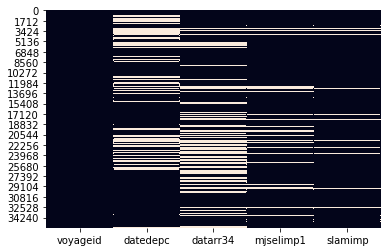

In [30]:
# select the most interesting columns
# spss code book available here:
# https://slavevoyages.org/voyage/downloads#full-versions-of-the-trans-atlantic-slave-trade-database/0/en/

keep_cols = ['voyageid',     # unique id for voyage
             'datedepc',     # year departed
             'datarr34',    # year arrived
             'mjselimp1',      # Imputed principal place of slave disembarkation -- broad region
#             'embport',      # where ship embarked on journey -- for later use
             'slamimp',      # imputed number of enslaved people on board
#             'jamcaspr'      # Sterling cash price (of slaves) in Jamaica -- Not enough data here tbh
            ]

# throw out all but these columns
trade = trade_raw[keep_cols]

# original format encodes missing data as ' ' rather than NA; fix this
# https://stackoverflow.com/questions/54508137/check-if-pandas-dataframe-cell-contains-certain-string
trade = trade.replace(' ', np.nan)     

# trade.to_csv('testing_trade.csv')
# trade['datedepc'].unique()


# explore NaNs using seaborn heatmap
sns.heatmap(trade.isnull(),cbar=False)

In [31]:
# how many voyages would we lose if we drop the ones that don't have a year recorded?
(trade['datedepc'].isna().sum() / trade['datedepc'].count() ) * 100
# answer: 36%... :/ not so great. let's find a different solution

# this is super hacky... I am adding the two types of date (date of dep, date of arr) together and then will round
# first must replace all NAs with 0
trade['datedepc'] = trade['datedepc'].replace(np.nan, '0')
trade['datedepc'] = trade['datedepc'].astype(str).astype(int)
trade['datarr34'] = trade['datarr34'].replace(np.nan, '0')
trade['datarr34'] = trade['datarr34'].astype(str).astype(int)

# I'm going to pick the higher date
# https://stackoverflow.com/questions/12169170/find-the-max-of-two-or-more-columns-with-pandas
trade['date'] = trade[['datedepc', 'datarr34']].max(axis = 1)

# check the range of this new column to see that there are reasonable year values everywhere
# trade['date'].unique()
# there are still some values of 0. let's cut those out.
# first check how much we would lose
# start by replacing 0 with NA again
trade['date'] = trade['date'].replace(0, np.nan)
(trade['date'].isna().sum() / trade['date'].count() ) * 100
# answer: 10%. Kind of a lot. But will have to live with it.

# dropping rows if specific column contains NA
# drop rows w/ no data for date or imputed no. of enslaved people
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
trade = trade.dropna(subset=['date'])
trade = trade.dropna(subset=['slamimp'])

# how much data do we lose if we cut out rows where imputed slave destination is missing?
# another 10% -- too high.
# instead put "no data"
trade['mjselimp1'].isna().sum() / trade['mjselimp1'].count()
trade['mjselimp1'] = trade['mjselimp1'].replace(np.nan, 'Unknown Destination')

# sns.heatmap(trade.isnull(),cbar=False)
# now we have data everywhere!


In [32]:
### making the labels and columns a bit more intuitive

# I want my column names to make sense to me
new_colnames = {
    'voyageid' : 'voyageid',
    'datedepc' : 'datedep',
    'datarr34' : 'datearr',
    'mjselimp1' : 'destination',
    'slamimp' : 'no_enslaved'
}
trade = trade.rename(new_colnames, axis = 1)

# now replace the values in the destination column with place names
new_dest = {
    '10000' : 'Europe',
    '20000' : 'Mainland North America',
    '30000' : 'Caribbean',
    '40000' : 'Spanish American Mainland',
    '50000' : 'Brazil',
    '60000' : 'Africa',
    '80000' : 'Other',
    'Unknown Destination' : 'Unknown Destination'
}

trade = trade.replace(new_dest)
trade

# need to turn no_enslaved into numbers.
trade['no_enslaved'] = trade['no_enslaved'].astype(str).astype(int)
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31372 entries, 0 to 35935
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   voyageid     31372 non-null  int64  
 1   datedep      31372 non-null  int64  
 2   datearr      31372 non-null  int64  
 3   destination  31372 non-null  object 
 4   no_enslaved  31372 non-null  int64  
 5   date         31372 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


## Making graphs

What am I trying to compare?

- x = average number of slaves on ship
- y = number of voyages
- number of dots = region of slave destination
- dot size = total number of slaves sold
- animation: over time (i.e. every graph is snapshot of one year)

### Step 1: Group data

Grouping:
* By year

And separately find (for later merging):
* No. voyages
* Total enslaved people sold
* Average number of slaves on ship

Later we will stack by region.

In [44]:
# group data by year

#### Q # How can we make it count only one column that we're interested in???

## first: pull out separate data sets so we can a) create years as time line, b) group by region of destination
# then we can stack :)

# voyages set
trade_voyages = trade.groupby(['destination', 'date']).count()
trade_voyages = pd.DataFrame(trade_voyages['voyageid'])
# then rename to reflect averaging
trade_voyages = trade_voyages.rename({'voyageid' : 'no_voyages'}, axis = 1)
trade_voyages

# average enslaved set
trade_av_enslaved = trade.groupby(['destination', 'date']).mean()
trade_av_enslaved = pd.DataFrame(trade_av_enslaved['no_enslaved'])
# then rename to reflect averaging
trade_av_enslaved = trade_av_enslaved.rename({'no_enslaved' : 'av_enslaved'}, axis = 1)
trade_av_enslaved

# total enslaved people per voyage
trade_total = trade.groupby(['destination', 'date']).sum()
trade_total = pd.DataFrame(trade_total['no_enslaved'])
# and rename to reflect that this is now a total
trade_total = trade_total.rename({'no_enslaved' : 'total_enslaved'}, axis = 1)
trade_total

total_enslaved
destination         date                  
Africa              1589.0             319
                    1647.0             155
                    1652.0             291
                    1654.0             291
                    1657.0             191
...                                    ...
Unknown Destination 1850.0             277
                    1851.0             367
                    1852.0             367
                    1857.0             569
                    1859.0             559

[1335 rows x 1 columns]

In [62]:
## merge into one data set

trade_final = trade_total.join(trade_av_enslaved)
trade_final = trade_final.join(trade_voyages)
trade_final.describe()

,total_enslaved,av_enslaved,no_voyages
count,1335.000000,1335.000000,1335.000000
mean,6300.172285,253.208147,23.499625
std,11073.281410,94.998653,40.126017
min,3.000000,3.000000,1.000000
25%,518.000000,193.500000,2.000000
50%,1626.000000,250.290909,7.000000
75%,6198.000000,294.950000,25.000000
max,71239.000000,719.357143,271.000000


In [101]:
# stack stack stack!

strade = trade_final.stack()
strade.head()

destination  date                  
Africa       1589.0  total_enslaved    319.0
                     av_enslaved       319.0
                     no_voyages          1.0
             1647.0  total_enslaved    155.0
                     av_enslaved       155.0
dtype: float64

,total_enslaved,av_enslaved,no_voyages
destination,,,
Africa,1032.0,129.000000,8.0
Brazil,44636.0,368.892562,121.0
Caribbean,31772.0,248.218750,128.0
Europe,NaN,NaN,NaN
Mainland North America,1010.0,168.333333,6.0
Other,192.0,192.000000,1.0
Spanish American Mainland,353.0,353.000000,1.0
Unknown Destination,3408.0,162.285714,21.0


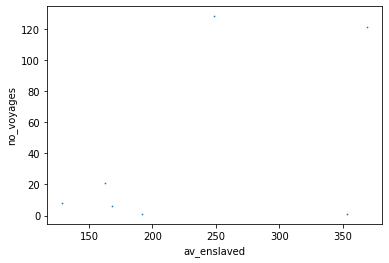

In [110]:
f_stack = strade.unstack(1)
f_stack
f_stack2 = f_stack[1817]
f_stack2
f_stack3 = f_stack2.unstack(1)
f_stack3.plot.scatter('av_enslaved', 'no_voyages', s=0.5)
f_stack3

Text(0, 0.5, 'No. Voyages')

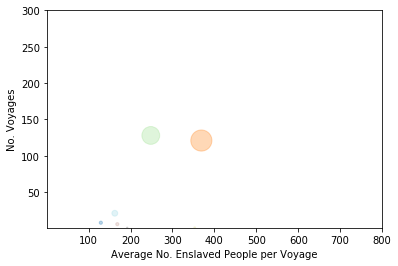

In [65]:
# THE PLOT THICKENS.

cmap = plt.get_cmap('tab20', lut = len(f_stack)).colors
# lut controls length of colour array. Default is 20, but we want it to be the same length as our no. of countries, so we are going to make sure it's the same length as the data frame by using lut = len(df6)

# set up parameters for using in plot generation
x = f_stack['av_enslaved']
y = f_stack['no_voyages']
sizes = f_stack['total_enslaved']/ 100 # in 100s

fig = plt.scatter(x, y,
            s = sizes,
            c = cmap,     # cmap was defined above: override default len of 20 colours
            alpha=0.3)

plt.axis([1, 800, 1, 300])
plt.xlabel('Average No. Enslaved People per Voyage')
plt.ylabel('No. Voyages')


## Use loop to do this repeatedly

In [102]:
# make a list of the years
year_list_pre = trade_final.reset_index()
year_list = list(year_list_pre['date'].unique())
year_list = sorted(year_list)
year_list = [int(x) for x in year_list]
# year_list

In [111]:
strade

destination          date                  
Africa               1589.0  total_enslaved    319.0
                             av_enslaved       319.0
                             no_voyages          1.0
                     1647.0  total_enslaved    155.0
                             av_enslaved       155.0
                                               ...  
Unknown Destination  1857.0  av_enslaved       569.0
                             no_voyages          1.0
                     1859.0  total_enslaved    559.0
                             av_enslaved       559.0
                             no_voyages          1.0
Length: 4005, dtype: float64

In [121]:
df_initial = strade.unstack(1)

makePlot(df_initial, 1520)

# Write a function that will create the plots
def makePlot(df_initial, year):
    
    # select data for the year we are interested in
    df_temp = df_initial[year]
    df_temp = df_temp.unstack(1)
    
    # set some variables that will always be the same across all plots
    x = df_temp['av_enslaved']
    y = df_temp['no_voyages']
    sizes = df_temp['total_enslaved']/ 100 # in 100s
    cmap = plt.get_cmap('tab20', lut = len(df_temp)).colors

    # generate plot
    fig = plt.scatter(x, y,
                s = sizes,
                c = cmap,     # cmap was defined above: override default len of 20 colours
                alpha=0.3)

    plt.axis([1, 500, 1, 300])
    plt.xlabel('Average No. Enslaved People per Voyage')
    plt.ylabel('No. Voyages')
    plt.title(str(year))

    # save plot
    plt.savefig('scatter_enslaved' + str(year) + '.png', dpi = 150)
    plt.clf()       # close the plot we created, or they will all get overlaid
    
    return

### now loop through all of the years in the year list!
for moment in year_list:
    makePlot(df_initial, moment)

<Figure size 432x288 with 0 Axes>

## Make gif

In [123]:
# code from Kristian's textbook

images = []

for i in year_list:
    filename = 'scatter_enslaved{}.png'.format(i)
    images.append(imageio.imread(filename))

imageio.mimsave('output_enslaved.gif', images, fps=20)